<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202410_AML/blob/main/Talleres/Taller%204/Taller%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

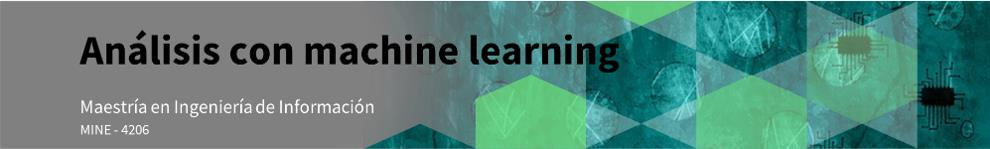

- **Integrante 1:** Lina María Gómez Mesa
- **Integrante 2:** María Catalina Ibáñez Piñeres

# Contexto y objetivos.

### **Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado**

Una paleta de colores es un conjunto de tonos que se utilizan juntos para crear un efecto armonioso, coherente y atractivo en las representaciones visuales (diseño gráfico, cine, fotografía, pintura, etc.), así como para transmitir mensajes y generar emociones determinados, de acuerdo con la intencionalidad del autor de la obra.    

En un contexto de amplia demanda de herramientas que puedan asistir a diseñadores gráficos, directores de arte, pintores y creadores de contenido, entre otros, para la selección rápida y adecuada de los colores apropiados para sus obras, una aplicación para configurar paletas de colores a partir de imágenes sería de mucha utilidad.  

Una vía para lograr una herramienta como esta es utilizar técnicas de machine learning no supervisado sobre imágenes para visualizar la distribución de los colores presentes en estas y generar, de manera automática, modelos de paletas de colores. En esta primera aproximación el método va a permitir identificar los colores en una imagen para construir un muestrario por similitud de píxeles, lo cual puede ser muy útil para estudios de marketing, psicología, medicina, arte, ambiente, entre otros. Por ejemplo, se podrían extraer los colores de las diferentes superficies de la Tierra en una imagen satelital para estudiar la distribución de la vegetación o de la contaminación.

Los datos están asociados con imágenes de obras de arte. Pueden ser descargados a partir de este [enlace](https://www.kaggle.com/datasets/steubk/wikiart).  

# Actividades a realizar

1. Recopilación de las imágenes a partir del repositorio. La idea es seleccionar un conjunto diverso de muestras en diferentes estilos artísticos (no más de 10).

2. Preparación de las imágenes para el entrenamiento y prueba del modelo. Para este paso construir un pipeline que integre las transformaciones que se consideren adecuadas.

3. Desarrollo del modelo de agrupación para identificar los colores presentes en las imágenes.

4. Creación de un modelo que transforme los grupos de colores identificados en un muestrario representativo. Adicionalmente, se debe mostrar la distribución de los colores de la imagen en un espacio de dos dimensiones utilizando t-SNE.

**NOTA**: La calificación será sobre notebook ejecutado.

### **Consideraciones:**
- El algoritmo de agrupación a utilizar queda a consideración de cada grupo, pero es importante justificar la elección.

- Se debe evidenciar el desempeño del método construido mostrando la paleta para al menos cuatro (4) imágenes de diferentes estilos, con la visualización de la distribución de colores en el espacio de dos dimensiones.

- Un diagrama general del método que se quiere desarrollar se muestra en la siguiente figura:


# 0. Importar librerías

In [6]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import pandas as pd
import requests
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

pd.set_option('display.max_colwidth', None)

## Punto 1: Recopilación de Imágenes

In [7]:
img_classes = pd.read_csv("Data/classes.csv")

sample_10 = pd.read_csv("Data/sample_10.csv", header=None)
lista = sample_10[0].unique()
img_selected = []
diccio = {}
for img in range(len(lista)):
    url =lista[img].split("4202543/")[1].split("?X-Goog-Algorithm")[0]
    img_selected.append(url)
    diccio[url] = lista[img][1:-1]
img_selected

['Contemporary_Realism/lucian-freud_factory-in-north-london.jpg',
 'Early_Renaissance/filippo-lippi_disputation-in-the-synagogue-detail-1465.jpg',
 'Impressionism/armand-guillaumin_moulins-en-hollandee-1904.jpg',
 'Cubism/albert-gleizes_untitled-3.jpg',
 'Naive_Art_Primitivism/andre-bauchant_le-bouquet-1928.jpg',
 'Northern_Renaissance/albrecht-altdorfer_the-battle-of-issus-1529.jpg',
 'Pop_Art/aldo-mondino_collage-1973.jpg',
 'Symbolism/a.y.-jackson_smart-river-alaska-1945.jpg',
 'Fauvism/andre-derain_figures-from-a-carnival.jpg',
 'Art_Nouveau_Modern/aladar-korosfoi-kriesch_lady-with-tiara.jpg']

In [8]:
filtered_img_classes = img_classes[img_classes['filename'].isin(img_selected)]
filtered_img_classes

,filename,artist,genre,description,phash,width,height,genre_count,subset
2262,Art_Nouveau_Modern/aladar-korosfoi-kriesch_lady-with-tiara.jpg,aladar korosfoi kriesch,['Art Nouveau Modern'],lady-with-tiara,cc2bb3d64c799039,1382,1740,1,train
10485,Contemporary_Realism/lucian-freud_factory-in-north-london.jpg,lucian freud,['Contemporary Realism'],factory-in-north-london,ddc75638863a2ac6,1394,1382,1,train
10622,Cubism/albert-gleizes_untitled-3.jpg,albert gleizes,['Cubism'],untitled-3,cfb63198ce649893,1936,1382,1,train
12821,Early_Renaissance/filippo-lippi_disputation-in-the-synagogue-detail-1465.jpg,filippo lippi,['Early Renaissance'],disputation-in-the-synagogue-detail-1465,81367edb17564c4a,1382,1921,1,train
18528,Fauvism/andre-derain_figures-from-a-carnival.jpg,andre derain,['Fauvism'],figures-from-a-carnival,b08bcd2083f2decd,1897,1382,1,train
21099,Impressionism/armand-guillaumin_moulins-en-hollandee-1904.jpg,armand guillaumin,['Impressionism'],moulins-en-hollandee-1904,9ef2e00149ff0f31,1718,1382,1,train
32815,Naive_Art_Primitivism/andre-bauchant_le-bouquet-1928.jpg,andre bauchant,['Naive Art Primitivism'],le-bouquet-1928,c296591b37643ccb,1382,1658,1,train
34999,Northern_Renaissance/albrecht-altdorfer_the-battle-of-issus-1529.jpg,albrecht altdorfer,['Northern Renaissance'],the-battle-of-issus-1529,9d8cc47c2c8cea4f,1382,1784,1,train
59251,Symbolism/a.y.-jackson_smart-river-alaska-1945.jpg,a.y. jackson,"['Symbolism', 'Art Nouveau Modern']",smart-river-alaska-1945,d23fa9a0d78f0d28,1877,1382,2,train
73379,Pop_Art/aldo-mondino_collage-1973.jpg,aldo mondino,['Pop Art'],collage-1973,ba23c43f93c4f8c2,1382,1742,1,test


In [9]:
filtered_img_classes.loc[:, 'url'] = filtered_img_classes['filename'].map(diccio)

C:\Users\lgome\AppData\Local\Temp\ipykernel_31668\4201899911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_img_classes.loc[:, 'url'] = filtered_img_classes['filename'].map(diccio)


In [10]:
def download_image(url, filename):
    response = requests.get(url)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

for index, row in filtered_img_classes.iterrows():
    url = row['url']
    filename = row['filename']
    download_image(url, filename)

In [11]:
from PIL import Image

def load_image(filename):
    try:
        img = Image.open(filename)
        img = img.convert("RGB")
        return img
    except FileNotFoundError:
        return None

filtered_img_classes.loc[:, 'image'] = filtered_img_classes['filename'].apply(load_image)

C:\Users\lgome\AppData\Local\Temp\ipykernel_31668\4036918011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_img_classes.loc[:, 'image'] = filtered_img_classes['filename'].apply(load_image)


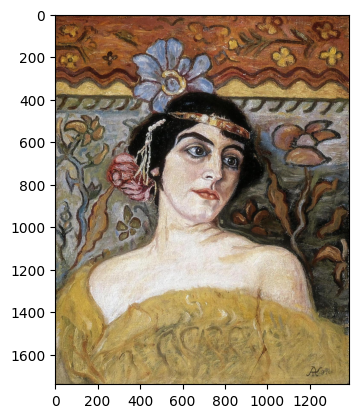

In [12]:
import matplotlib.pyplot as plt

image = filtered_img_classes["image"].iloc[0]
plt.imshow(image)
plt.show()

## Punto 2: Preparación de imágenes para la prueba del modelo

In [29]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

class ImageReader:
    """Class to read and preprocess images.

    Attributes:
        - n_images (int): Number of images to read
        - file_type (str): File type of the images
        - directory (str): Directory where the images are stored

    Preprocessing includes:
    - Reading the images
    - Rescaling the images keeping the aspect ratio
    """

    def __init__(self, filtered_img: pd.DataFrame, scale: float = 0.1):
        self.images_names = []
        self.filter = filtered_img
        self.n_images = len(self.filter)
        self.images = self.read_images()
        self.images = self.rescale_images(self.images, scale)

    def read_images(self):
        """Read images from a directory and store them in a list"""
        images = []
        for filename in self.filter["filename"]:
            image = cv2.imread(filename)
            if image is not None:
                images.append(image)
                self.images_names.append(filename)
        return images

    def rescale_images(self, images: list, scale: float = 0.5):
        """Rescale images keeping the aspect ratio"""
        rescaled_images = []
        for image in images:
            width = int(image.shape[1] * scale)
            height = int(image.shape[0] * scale)
            dim = (width, height)
            rescaled_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            rescaled_images.append(rescaled_image)
        return rescaled_images

    def plot_images(self):
        """Plot the images"""
        n_cols = 3
        n_rows = int(np.ceil(self.n_images / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        for i, ax in enumerate(axs.flat):
            if i < self.n_images:
                ax.imshow(cv2.cvtColor(self.images[i], cv2.COLOR_BGR2RGB))
                ax.axis('off')
        plt.show()


class ImageDataProcessor:
    """Class to process images and extract features.

    Attributes:
        - image_reader: Instance of the ImageReader class.

    Methods:
        - extract_features: Extract features from the images
    """

    def __init__(self, image_reader: ImageReader):
        self.image_reader = image_reader
        if len(self.image_reader.images) > 1:
            self.image_reader.images = self.resize_images((100, 100))
        self.features = self.extract_features()

    def extract_features(self):
        """Create DataFrame with RGB values of the images"""
        features = []
        for image in self.image_reader.images:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image.reshape((image.shape[0] * image.shape[1], 3))
            features.append(image)
        features = np.concatenate(features, axis=0)
        features = pd.DataFrame(features, columns=['r', 'g', 'b'])
        return features
    
    def resize_images(self, size: tuple):
        """Resize images to a given size"""
        resized_images = []
        for image in self.image_reader.images:
            resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            resized_images.append(resized_image)
        return resized_images

In [30]:
images = ImageReader(filtered_img=filtered_img_classes)

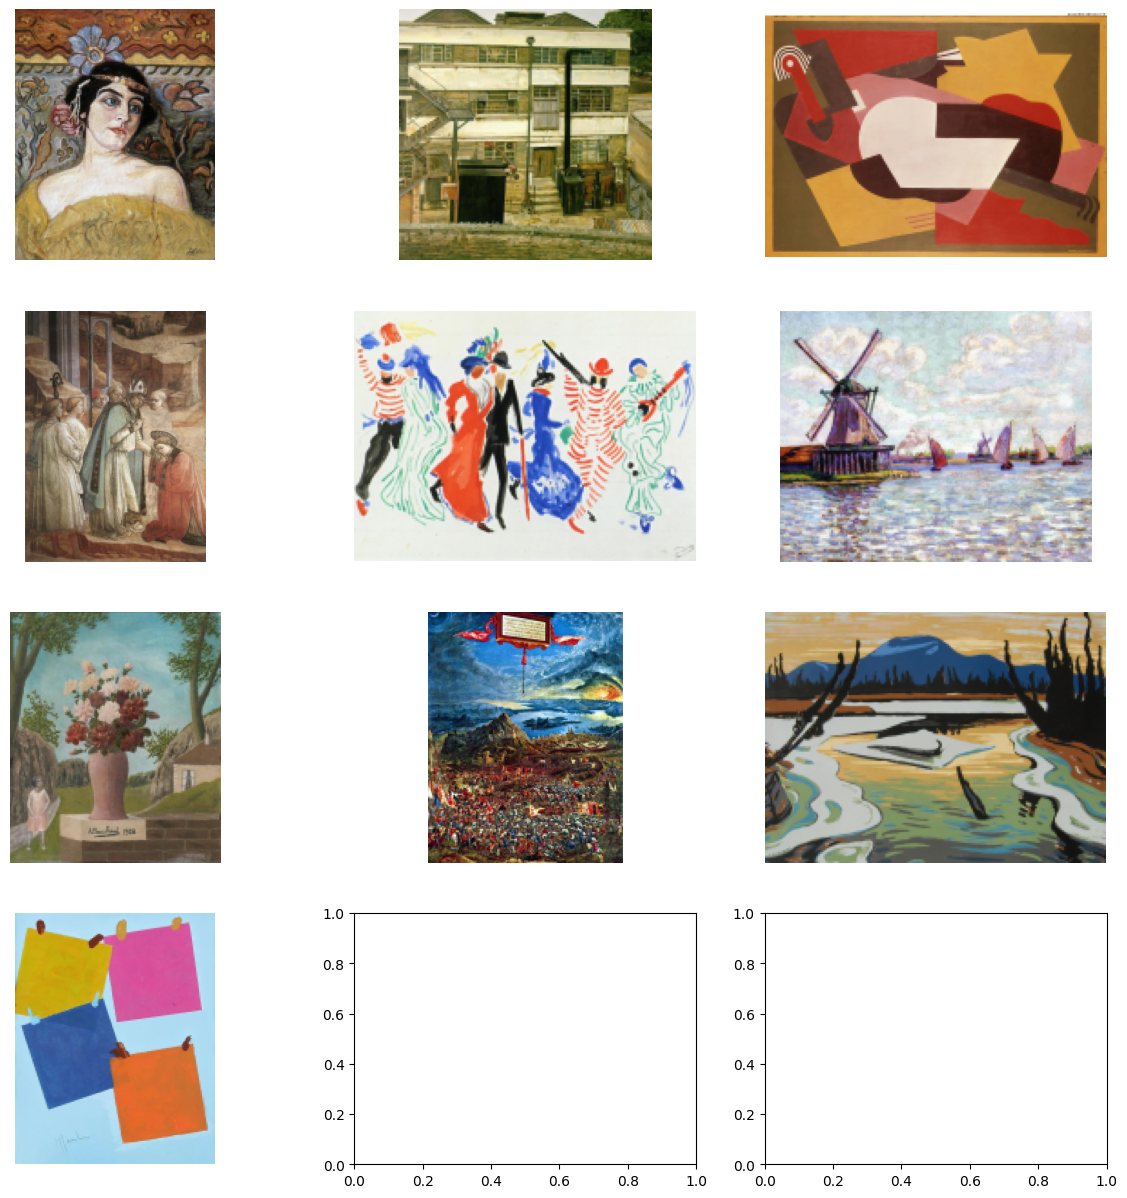

In [31]:
images.plot_images()

## Punto 3: Desarrollo del modelo de agrupación para identificar los colores presentes en las imágenes